In [1]:
# hide
# default_exp datasets

from nbdev.showdoc import *

# Primary Baseline
> Murdock, B. B., Jr. (1962). The serial position effect of free recall. Journal of Experimental Psychology, 64(5), 482-488. https://doi.org/10.1037/h0045106  

We'll start by analyzing how well our models account for a classical dataset where each item is encoded just once at each trial.

## The Dataset

Our data structure associated with Murdock (1962) has three `LL` structures that each seem to correspond to a different data set with different list lengths.  Inside
each structure is:
- `recalls` with 1200 rows and 50 columns. Each row presumably represents a subject, and each column seems to
  correspond to a recall position, with -1 coded for intrusions. `MurdData_clean.mat` probably doesn't have these
  intrusions coded at all.
- `listlength` is an integer indicating how long the studied list is.
- `subject` is a 1200x1 vector coding the identities of each subject for each row. Each subject seems to get 80 rows a
  piece. He really got that much data for each subject? 
- `session` similarly codes the index of the session under consideration, and it's always 1 in this case.
- `presitemnumbers` probably codes the number associated with each item. Is just its presentation index.

At first, we will only work with on `LL` structure at a time.

We need a few structures extracted from a selected dataset.
1. A `trials` array, where each row identifies a unique trial of responses and each call corresponds to a unique
   recall index. Entries are 0 where no item is recalled, -1 where an inapplicable item is recalled, while other
   entries are 1-indexed based on the order in which they were presented in the list.
2. A "long' format table representing recall data as specified in the [`psifr`
   documentation](https://psifr.readthedocs.io/en/latest/guide/import.html).

In [2]:
# export
# hide
import scipy.io as sio
import numpy as np
import pandas as pd
from psifr import fr

def prepare_murddata(path, dataset_index):
    """
    Prepares data formatted like `data/MurdData_clean.mat` for fitting.

    Loads data from `path` with same format as `data/MurdData_clean.mat` and 
    returns a selected dataset as an array of unique recall trials and a 
    dataframe of unique study and recall events organized according to `psifr`
    specifications.  

    **Arguments**:  
    - path: source of data file  
    - dataset_index: index of the dataset to be extracted from the file

    **Returns**:
    - trials: int64-array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index.  
    - merged: as a long format table where each row describes one study or 
        recall event.  
    - list_length: length of lists studied in the considered dataset
    """
    # load all the data
    matfile = sio.loadmat(path, squeeze_me=True)
    murd_data = [matfile['data'].item()[0][i].item() for i in range(3)]
    
    # encode dataset into psifr format
    trials, list_length, subjects = murd_data[dataset_index][:3]
    trials = trials.astype('int64')
    
    data = []
    for trial_index, trial in enumerate(trials):

        # every time the subject changes, reset list_index
        if not data or data[-1][0] != subjects[trial_index]:
            list_index = 0
        list_index += 1

        # add study events
        for i in range(list_length):
            data += [[subjects[trial_index], 
                      list_index, 'study', i+1, i+1]]

        # add recall events
        for recall_index, recall_event in enumerate(trial):
            if recall_event != 0:
                data += [[subjects[trial_index], list_index, 
                          'recall', recall_index+1, recall_event]]

    data = pd.DataFrame(data, columns=[
        'subject', 'list', 'trial_type', 'position', 'item'])
    merged = fr.merge_free_recall(data)
    return trials, merged, list_length

In [3]:
try:
    show_doc(prepare_murddata, title_level=3)
except:
    pass

<h3 id="prepare_murddata" class="doc_header"><code>prepare_murddata</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h3>

> <code>prepare_murddata</code>(**`path`**, **`dataset_index`**)

Prepares data formatted like `data/MurdData_clean.mat` for fitting.

Loads data from `path` with same format as `data/MurdData_clean.mat` and 
returns a selected dataset as an array of unique recall trials and a 
dataframe of unique study and recall events organized according to `psifr`
specifications.  

**Arguments**:  
- path: source of data file  
- dataset_index: index of the dataset to be extracted from the file

**Returns**:
- trials: int64-array where rows identify a unique trial of responses and 
    columns corresponds to a unique recall index.  
- merged: as a long format table where each row describes one study or 
    recall event.  
- list_length: length of lists studied in the considered dataset

We can generate a quick preview of some datasets using this function.

In [4]:
murd_trials, murd_events, murd_length = prepare_murddata(
    '../../data/MurdData_clean.mat', 0)

murd_events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


Let's also visualize the variation between subjects in dataset with respect to our main organizational metrics.

In [5]:
# export

import pandas as pd
import seaborn as sns
from psifr import fr
import matplotlib.pyplot as plt

def visualize_individuals(data, data_query):
    """
    Visualize variation between subjects in dataset wrt key organizational metrics.
    """

    # generate data-based spc, pnr, lag_crp
    data_spc = fr.spc(data).query(data_query).reset_index()
    data_pfr = fr.pnr(data).query('output <= 1').query(data_query).reset_index()
    data_lag_crp = fr.lag_crp(data).query(data_query).reset_index()
    
    # spc
    g = sns.FacetGrid(dropna=False, data=data_spc)
    g.map_dataframe(sns.lineplot, x='input', y='recall', hue='subject')
    g.set_xlabels('Serial position')
    g.set_ylabels('Recall probability')
    plt.title('P(Recall) by Serial Position Curve')
    g.set(ylim=(0, 1))
    plt.show()
    
    # pfr
    h = sns.FacetGrid(dropna=False, data=data_pfr)
    h.map_dataframe(sns.lineplot, x='input', y='prob', hue='subject')
    h.set_xlabels('Serial position')
    h.set_ylabels('Probability of First Recall')
    plt.title('P(First Recall) by Serial Position')
    h.set(ylim=(0, 1))
    
    # lag crp
    max_lag = 5
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    i = sns.FacetGrid(dropna=False, data=data_lag_crp)
    i.map_dataframe(
        lambda data, **kws: sns.lineplot(data=data.query(filt_neg),
                                         x='lag', y='prob', hue='subject', **kws))
    i.map_dataframe(
        lambda data, **kws: sns.lineplot(data=data.query(filt_pos),
                                         x='lag', y='prob', hue='subject', **kws))
    i.set_xlabels('Lag')
    i.set_ylabels('Recall Probability')
    plt.title('Recall Probability by Item Lag')
    i.set(ylim=(0, 1))

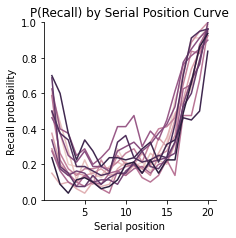

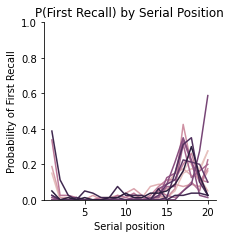

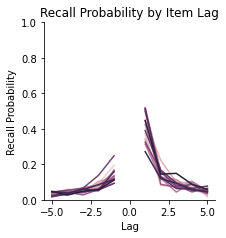

In [6]:
visualize_individuals(murd_events, 'subject > -1')

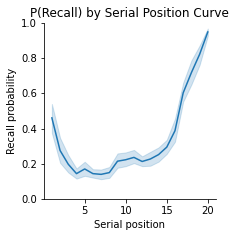

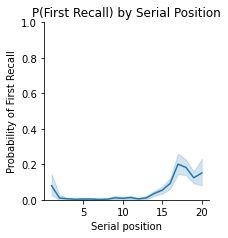

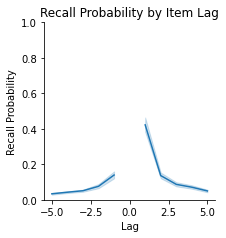

In [8]:
from instance_cmr.datasets import visualize_aggregate

visualize_aggregate(murd_events, 'subject > -1')